In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

In [2]:
def load_data(gen_paths, forg_paths):
    train_data, train_labels = [], []
    test_data, test_labels = [], []

    for data, paths in enumerate(gen_paths):
        for path in paths:
            image = cv2.imread(path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            if data == 3:  
                test_data.append(image)
                test_labels.append(1)
            else:
                train_data.append(image)
                train_labels.append(1)

    for data, paths in enumerate(forg_paths):
        for path in paths:
            image = cv2.imread(path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            if data == 3:  
                test_data.append(image)
                test_labels.append(0)
            else:
                train_data.append(image)
                train_labels.append(0)

    return (np.array(train_data), np.array(train_labels)), (np.array(test_data), np.array(test_labels))

In [3]:
gen_paths = [
    glob.glob('Dataset_Signature_Final/Dataset/dataset1/real/*.*'),
    glob.glob('Dataset_Signature_Final/Dataset/dataset2/real/*.*'),
    glob.glob('Dataset_Signature_Final/Dataset/dataset3/real/*.*'),
     glob.glob('Dataset_Signature_Final/Dataset/dataset4/real1/*.*')
]

forg_paths = [
    glob.glob('Dataset_Signature_Final/Dataset/dataset1/forge/*.*'),
    glob.glob('Dataset_Signature_Final/Dataset/dataset2/forge/*.*'),
    glob.glob('Dataset_Signature_Final/Dataset/dataset3/forge/*.*'),
    glob.glob('Dataset_Signature_Final/Dataset/dataset4/forge/*.*')
]


In [4]:
(train_data, train_labels), (test_data, test_labels) = load_data(gen_paths, forg_paths)

In [5]:
train_data = train_data / 255.0
test_data = test_data / 255.0
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training data shape: (540, 224, 224, 3)
Training labels shape: (540,)
Testing data shape: (180, 224, 224, 3)
Testing labels shape: (180,)


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(train_data, train_labels, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5096 - loss: 4.8020 - val_accuracy: 0.9907 - val_loss: 0.2104
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6287 - loss: 0.8007 - val_accuracy: 0.0185 - val_loss: 1.8379
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7669 - loss: 0.4904 - val_accuracy: 0.1481 - val_loss: 1.6767
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8126 - loss: 0.4418 - val_accuracy: 0.6667 - val_loss: 0.6140
Epoch 4: early stopping


In [10]:
predictions = model.predict(test_data).flatten()

average_threshold = np.mean(predictions)

predicted_labels = (predictions > average_threshold).astype(int)
predicted_labels

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0])

In [12]:
print(predicted_labels)
print(test_labels)

[0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.5944444444444444
Precision: 0.5934065934065934
Recall: 0.6


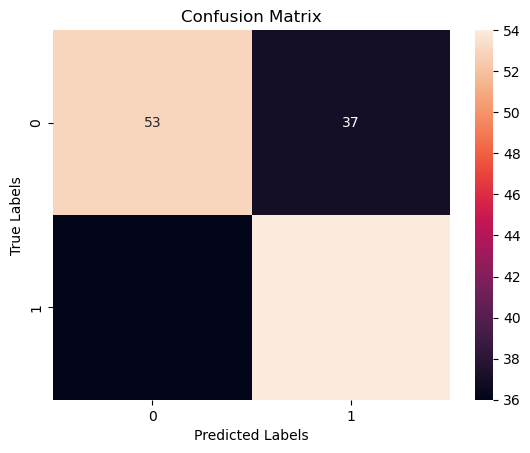

In [14]:
cm = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png') 
plt.show()


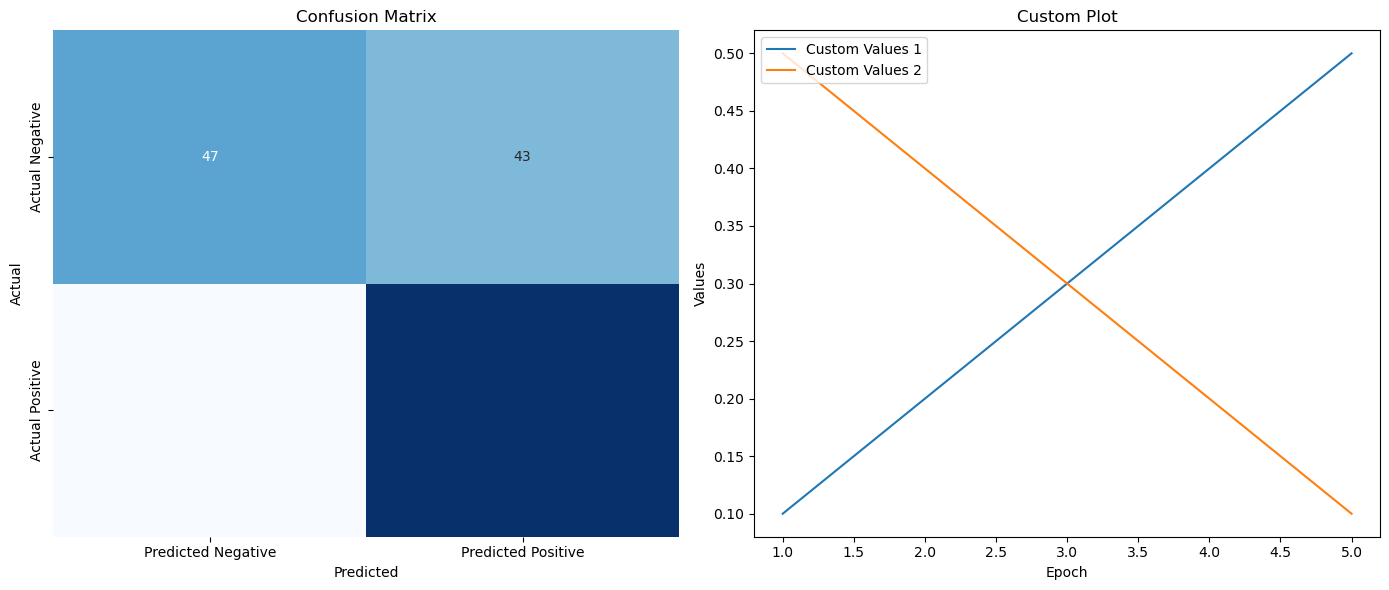

In [17]:
# Define the confusion matrix values
confusion_matrix = np.array([[47, 43],
                             [24, 66]])

# Create a DataFrame
df_cm = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the confusion matrix
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', ax=axs[0], cbar=False)
axs[0].set_title('Confusion Matrix')
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')

# Custom plot example (replace this with your custom plot)
# Example custom plot with dummy data
custom_values_1 = [0.1, 0.2, 0.3, 0.4, 0.5]
custom_values_2 = [0.5, 0.4, 0.3, 0.2, 0.1]
epochs = range(1, 6)

axs[1].plot(epochs, custom_values_1, label='Custom Values 1')
axs[1].plot(epochs, custom_values_2, label='Custom Values 2')
axs[1].set_title('Custom Plot')
axs[1].set_ylabel('Values')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('confusion_matrix_custom_plot.png')
plt.show()

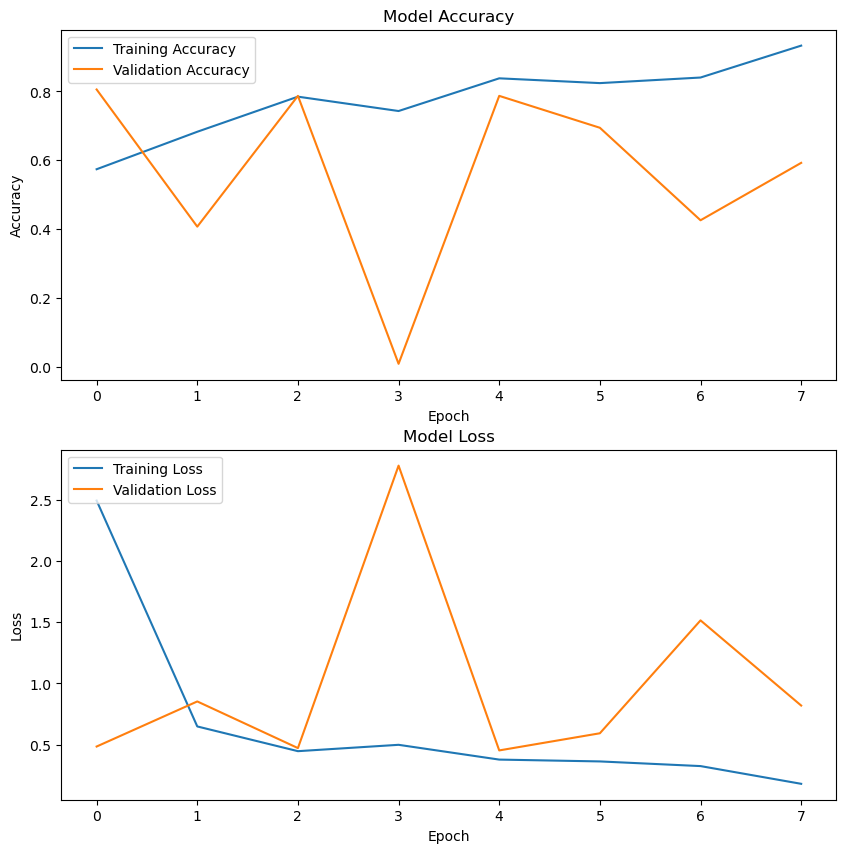

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')
plt.savefig('training_validation_plots.png') 
plt.show()